In [1]:
import torch
import os
import pandas as pd
import cxr_dataset as CXR
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics as sklm
from torch.autograd import Variable
import numpy as np
import warnings
import datetime
date_object = datetime.date.today()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore")

In [9]:
path_to_images = 'C:/NIH/co_occurrence_200/Cardiomegaly/2/'
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
data_transforms = {
        'val': transforms.Compose([
            transforms.Scale(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }
checkpoint_best = torch.load('checkpoint')
model = checkpoint_best['model']

In [2]:
import re

digits = re.compile(r'(\d+)')
def tokenize(filename):
    return tuple(int(token) if match else token
                 for token, match in
                 ((fragment, digits.search(fragment))
                  for fragment in digits.split(filename)))

In [3]:
def make_pred_multilabel(data_transforms, model, PATH_TO_IMAGES):
    """
    Gives predictions for test fold and calculates AUCs using previously trained model

    Args:
        data_transforms: torchvision transforms to preprocess raw images; same as validation transforms
        model: densenet-121 from torchvision previously fine tuned to training data
        PATH_TO_IMAGES: path at which NIH images can be found
    Returns:
        pred_df: dataframe containing individual predictions and ground truth for each test image
        auc_df: dataframe containing aggregate AUCs by train/test tuples
    """

    # calc preds in batches of 16, can reduce if your GPU has less RAM
    BATCH_SIZE = 4

    # set model to eval mode; required for proper predictions given use of batchnorm
    model.train(False)

    # create dataloader
    dataset = CXR.CXRDataset(
        path_to_images=PATH_TO_IMAGES,
        fold="test",
        transform=data_transforms['val'])
    
    dataloader = torch.utils.data.DataLoader(
        dataset, BATCH_SIZE, shuffle=False, num_workers=16)
    size = len(dataset)

    # create empty dfs
    pred_df = pd.DataFrame(columns=["Image Index"])
    true_df = pd.DataFrame(columns=["Image Index"])

    # iterate over dataloader
    for i, data in enumerate(dataloader):

        inputs, labels, _ = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        true_labels = labels.cpu().data.numpy()
        batch_size = true_labels.shape
        #print(inputs.shape)
        outputs = model(inputs)
        probs = outputs.cpu().data.numpy()

        # get predictions and true values for each item in batch
        for j in range(0, batch_size[0]):
            thisrow = {}
            truerow = {}
            thisrow["Image Index"] = dataset.df.index[BATCH_SIZE * i + j]
            truerow["Image Index"] = dataset.df.index[BATCH_SIZE * i + j]

            # iterate over each entry in prediction vector; each corresponds to
            # individual label
            for k in range(len(dataset.PRED_LABEL)):
                thisrow["prob_" + dataset.PRED_LABEL[k]] = probs[j, k]
                truerow[dataset.PRED_LABEL[k]] = true_labels[j, k]

            pred_df = pred_df.append(thisrow, ignore_index=True)
            true_df = true_df.append(truerow, ignore_index=True)

    #save_pred = os.path.join(PATH_TO_IMAGES, 'preds.csv')
    #pred_df.to_csv(save_pred, index=False)
    return pred_df

In [10]:
pred_df = make_pred_multilabel(data_transforms, model, path_to_images)

In [11]:
mean = pred_df.mean(axis=0)
std = pred_df.std(axis=0)

In [12]:
mean
std

prob_Atelectasis           0.042709
prob_Cardiomegaly          0.066287
prob_Consolidation         0.011254
prob_Edema                 0.005154
prob_Effusion              0.025521
prob_Emphysema             0.010015
prob_Fibrosis              0.010057
prob_Hernia                0.002690
prob_Infiltration          0.098334
prob_Mass                  0.011402
prob_Nodule                0.025742
prob_Pleural_Thickening    0.012366
prob_Pneumonia             0.005854
prob_Pneumothorax          0.013581
dtype: float64

prob_Atelectasis           0.042749
prob_Cardiomegaly          0.131072
prob_Consolidation         0.016780
prob_Edema                 0.009952
prob_Effusion              0.031421
prob_Emphysema             0.020381
prob_Fibrosis              0.014974
prob_Hernia                0.003500
prob_Infiltration          0.064581
prob_Mass                  0.040771
prob_Nodule                0.022362
prob_Pleural_Thickening    0.018220
prob_Pneumonia             0.005022
prob_Pneumothorax          0.022598
dtype: float64

In [30]:
result_df = pd.DataFrame()
result_df['pathology'] = pred_df.columns[1:].values 
result_df['mean_1'] = mean_1.values
result_df['std_1'] = std_1.values
result_df.head()

,pathology,mean_1,std_1
0,prob_Atelectasis,0.042867,0.047457
1,prob_Cardiomegaly,0.032924,0.071254
2,prob_Consolidation,0.009960,0.010439
3,prob_Edema,0.004741,0.013925
4,prob_Effusion,0.021881,0.033795


## In all check

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
data_transforms = {
        'val': transforms.Compose([
            transforms.Scale(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }
checkpoint_best = torch.load('checkpoint')
model = checkpoint_best['model']

PRED_LABEL = [
            'Atelectasis',
            'Cardiomegaly',
            'Effusion',
            'Infiltration',
            'Mass',
            'Nodule',
            'Pneumonia',
            'Pneumothorax',
            'Consolidation',
            'Edema',
            'Emphysema',
            'Fibrosis',
            'Pleural_Thickening',
            'Hernia']

In [1]:
for label in PRED_LABEL:
    base_dir = 'C:/NIH/co_occurrence/'
    path_base = os.path.join(base_dir, label)
    path_list = os.listdir(path_base)
    path_list.sort(key=tokenize)
    result_mean = pd.DataFrame()
    result_mean['pathology'] = new_row_name
    result_std = pd.DataFrame()
    result_std['pathology'] = new_row_name
    Pathology_result_df = pd.DataFrame()
    
    for n in range (len(path_list)):
        path_to_images = os.path.join(path_base, path_list[n])
        pred_df = make_pred_multilabel(data_transforms, model, path_to_images)
        pred_df['Image Index'] = str(n)+'_'+pred_df['Image Index']
        Pathology_result_df = Pathology_result_df.append(pred_df)
        print(len(Pathology_result_df))
        mean = pred_df.mean(axis=0)
        std = pred_df.sem(axis=0)
        mean_name = 'mean_' + str(n)
        std_name = 'std_'+str(n)
        result_mean[mean_name] = mean.values
        result_std[std_name] = std.values
        
    ############### save classification mean and std as .csv files ################
    result_mean = result_mean.T
    result_std = result_std.T
    result_basedir = 'C:/Users/peter/2080Ti/Jupyter/Fabian_experiment/result'
    result_dir = os.path.join(result_basedir, label)
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    mean_path = os.path.join(result_dir, 'mean.csv')
    std_path = os.path.join(result_dir, 'std.csv')
    result_path = os.path.join(result_dir, label+'_result.csv')
    result_mean.to_csv(mean_path, index=False)
    result_std.to_csv(std_path, index=False)
    Pathology_result_df.to_csv(result_path, index=False)
    
    ################ plot the results with error bar #################
    result_mean = pd.read_csv(mean_path, header = 0)
    result_std = pd.read_csv(std_path, header = 0)
    result_mean.columns = result_mean.iloc[0]
    result_std.columns = result_std.iloc[0]
    result_mean = result_mean.drop(result_mean.index[0])
    result_std = result_std.drop(result_std.index[0])
    
    fig, axs = plt.subplots(nrows=2, ncols=7, sharex=True)
    fig.set_size_inches(35.5, 15.5)
    count_num = 0
    x = np.arange(11) 
    x = x / 10 
    for i in range(2):
        for j in range(7):
            ax = axs[i,j]
            pathology = PRED_LABEL[count_num]
            y = result_mean[pathology].values.astype(float)
            yerr = result_std[pathology].values.astype(float)
            ax.errorbar(x, y, yerr=yerr, fmt='-o', ecolor='g', capsize=6)
            ax.set_yscale('log')
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.001, 1.0])
            ax.set_xlabel(label)
            ax.set_ylabel(pathology)
            count_num += 1
    
    fig_path = os.path.join(result_dir, 'figure.pdf')
    fig.savefig(fig_path)   # save the figure to file
    plt.close(fig)

NameError: name 'PRED_LABEL' is not defined

In [3]:
result_mean = pd.read_csv('C:/Users/peter/2080Ti/Jupyter/Fabian_experiment/result/Atelectasis/mean.csv', header = 0)
result_std = pd.read_csv('C:/Users/peter/2080Ti/Jupyter/Fabian_experiment/result/Atelectasis/std.csv', header = 0)
result_mean.columns = result_mean.iloc[0]
result_std.columns = result_std.iloc[0]

In [4]:
result_mean = result_mean.drop(result_mean.index[0])
result_std = result_std.drop(result_std.index[0])

In [5]:
result_mean.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1,0.04417280027270317,0.015490100844483094,0.01028445554804057,0.004566991829139624,0.018658037263026925,0.014576443217003543,0.011218639676371822,0.0023653439330755645,0.10203665262996219,0.010935116797976662,0.029706211926997638,0.013346772375356522,0.005161529802542646,0.01663093110941554
2,0.05133340500399936,0.017548011407530793,0.010833645381731913,0.004809972963407745,0.02147148123946681,0.01345875039609382,0.011480201922444394,0.0026331731246864365,0.10280980482674204,0.010306317904760363,0.02899315392342396,0.013483969645691105,0.005474598091066582,0.016236071591454675
3,0.06212831953307614,0.02020196423226116,0.011650996009469963,0.004840594464799324,0.023886724215117283,0.013880776202593552,0.01173535860501579,0.0029621481352041885,0.10453268180740997,0.009961529862310272,0.02829992561088875,0.01337649139892892,0.005756405192136299,0.016441595223761398
4,0.07441278726339806,0.021665478731125405,0.012451844022027217,0.0048143884821893156,0.025998645108265918,0.013785955235194707,0.012330156575801084,0.003386281610852166,0.10582800540048629,0.009497521032608347,0.028153855546494015,0.013647460947802757,0.006128420822264161,0.016461971668788464
5,0.08976295194483828,0.023410912746618124,0.01338152896927204,0.004557330612125952,0.029133788735009148,0.014075217995501588,0.012629706320629338,0.003917821665683732,0.10714610248943791,0.009448757855614531,0.027181834459886887,0.013741243102005684,0.006517837517807493,0.016640606833505444


In [12]:
MyEmptydf = pd.DataFrame()
len(MyEmptydf)
MyEmptydf = MyEmptydf.append(result_mean)
len(MyEmptydf)
MyEmptydf = pd.DataFrame()
len(MyEmptydf)

0

14

0

<ErrorbarContainer object of 3 artists>

(0.0, 1.0)

(0.001, 1.0)

Text(0.5, 0, 'Atelectasis')

Text(0, 0.5, 'Atelectasis')

<ErrorbarContainer object of 3 artists>

(0.0, 1.0)

(0.001, 1.0)

Text(0.5, 0, 'Atelectasis')

Text(0, 0.5, 'Cardiomegaly')

<ErrorbarContainer object of 3 artists>

(0.0, 1.0)

(0.001, 1.0)

Text(0.5, 0, 'Atelectasis')

Text(0, 0.5, 'Consolidation')

<ErrorbarContainer object of 3 artists>

(0.0, 1.0)

(0.001, 1.0)

Text(0.5, 0, 'Atelectasis')

Text(0, 0.5, 'Edema')

<ErrorbarContainer object of 3 artists>

(0.0, 1.0)

(0.001, 1.0)

Text(0.5, 0, 'Atelectasis')

Text(0, 0.5, 'Effusion')

<ErrorbarContainer object of 3 artists>

(0.0, 1.0)

(0.001, 1.0)

Text(0.5, 0, 'Atelectasis')

Text(0, 0.5, 'Emphysema')

<ErrorbarContainer object of 3 artists>

(0.0, 1.0)

(0.001, 1.0)

Text(0.5, 0, 'Atelectasis')

Text(0, 0.5, 'Fibrosis')

<ErrorbarContainer object of 3 artists>

(0.0, 1.0)

(0.001, 1.0)

Text(0.5, 0, 'Atelectasis')

Text(0, 0.5, 'Hernia')

<ErrorbarContainer object of 3 artists>

(0.0, 1.0)

(0.001, 1.0)

Text(0.5, 0, 'Atelectasis')

Text(0, 0.5, 'Infiltration')

<ErrorbarContainer object of 3 artists>

(0.0, 1.0)

(0.001, 1.0)

Text(0.5, 0, 'Atelectasis')

Text(0, 0.5, 'Mass')

<ErrorbarContainer object of 3 artists>

(0.0, 1.0)

(0.001, 1.0)

Text(0.5, 0, 'Atelectasis')

Text(0, 0.5, 'Nodule')

<ErrorbarContainer object of 3 artists>

(0.0, 1.0)

(0.001, 1.0)

Text(0.5, 0, 'Atelectasis')

Text(0, 0.5, 'Pleural')

<ErrorbarContainer object of 3 artists>

(0.0, 1.0)

(0.001, 1.0)

Text(0.5, 0, 'Atelectasis')

Text(0, 0.5, 'Pneumonia')

<ErrorbarContainer object of 3 artists>

(0.0, 1.0)

(0.001, 1.0)

Text(0.5, 0, 'Atelectasis')

Text(0, 0.5, 'Pneumothorax')

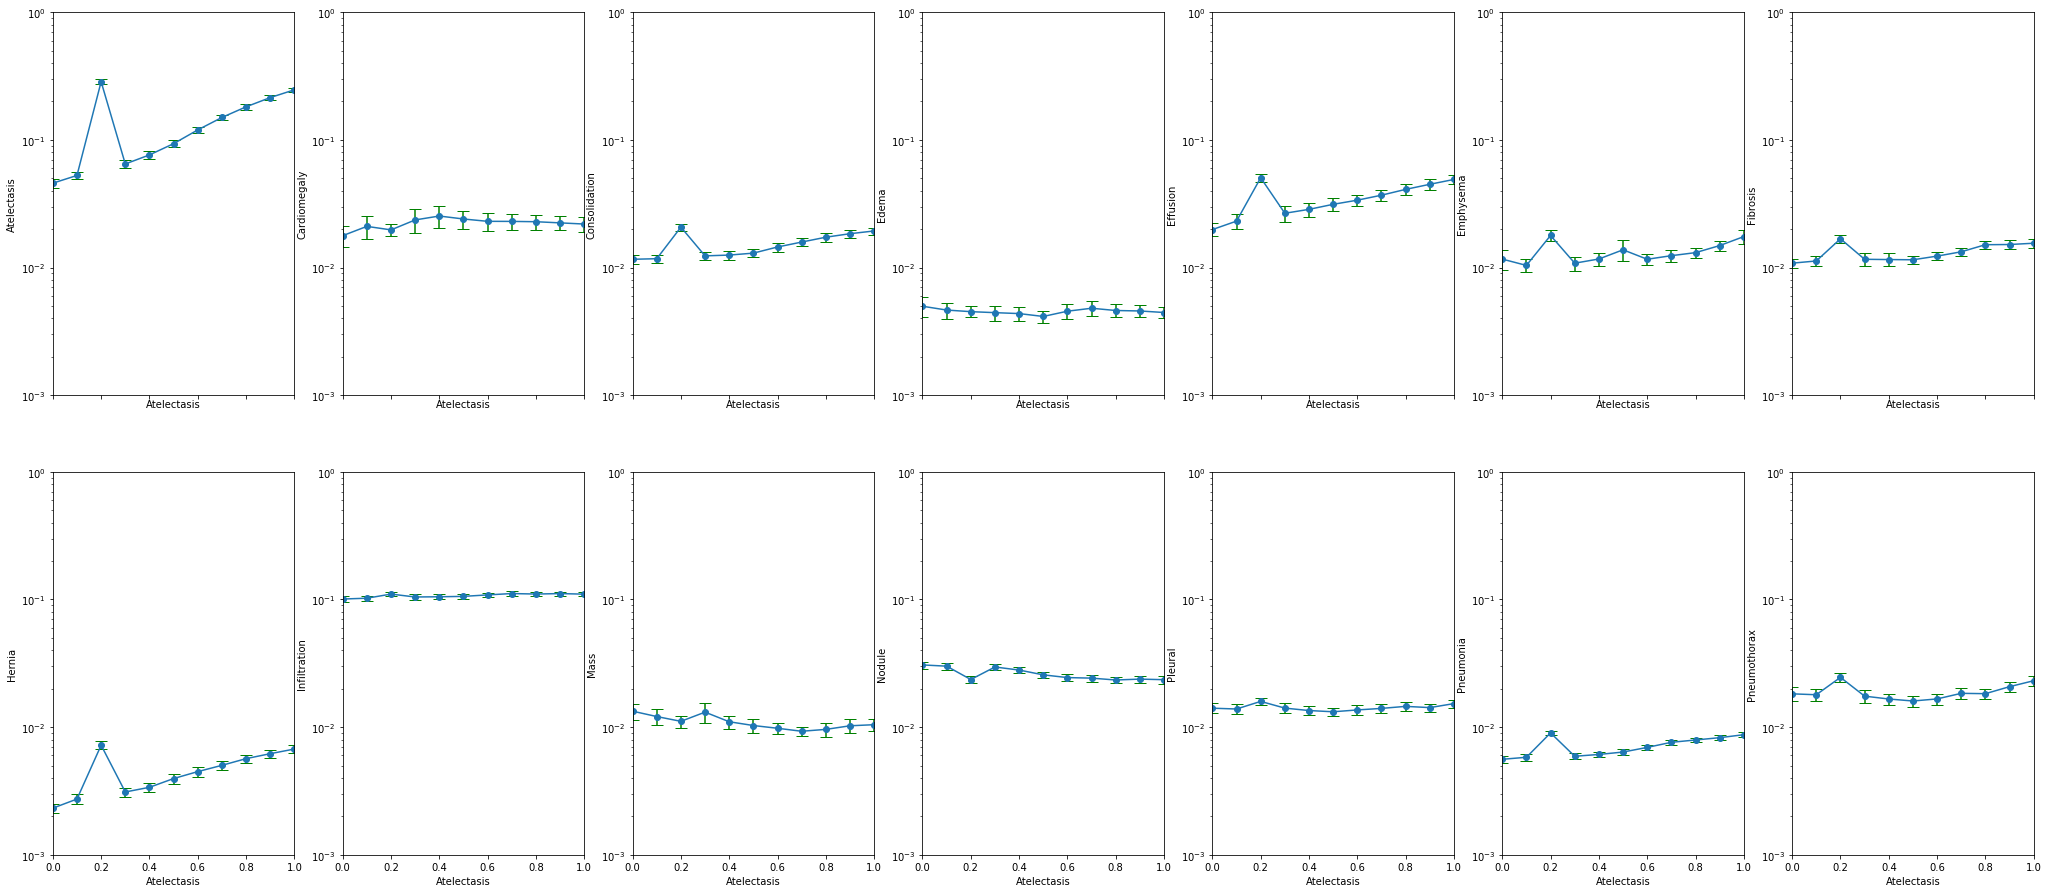

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=7, sharex=True)
fig.set_size_inches(35.5, 15.5)
count_num = 0
x = np.arange(11) 
x = x / 10 
for i in range(2):
    for j in range(7):
        ax = axs[i,j]
        pathology = new_row_name[count_num]
        y = result_mean[pathology].values.astype(float)
        yerr = result_std[pathology].values.astype(float)
        ax.errorbar(x, y, yerr=yerr, fmt='-o', ecolor='g', capsize=6)
        ax.set_yscale('log')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.001, 1.0])
        ax.set_xlabel(label)
        ax.set_ylabel(pathology)
        count_num += 1

In [5]:
pred_pd = pd.read_csv('C:/Users/peter/2080Ti/Jupyter/Fabian_experiment/preds.csv')
pred_pd.mean(axis=0)

prob_Atelectasis           0.142571
prob_Cardiomegaly          0.025346
prob_Consolidation         0.033273
prob_Edema                 0.016827
prob_Effusion              0.094957
prob_Emphysema             0.020726
prob_Fibrosis              0.015991
prob_Hernia                0.002277
prob_Infiltration          0.191990
prob_Mass                  0.041064
prob_Nodule                0.041099
prob_Pleural_Thickening    0.018387
prob_Pneumonia             0.015402
prob_Pneumothorax          0.052554
dtype: float64

In [6]:
row_name = pred_pd.columns[1:]
new_row_name = []
for i in range(len(row_name)):
    new_row_name.append(row_name[i].split('_')[1])
new_row_name[-3] = 'Pleural_Thickening'
new_row_name

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']